In [1]:
import os, math
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import get_ipython
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler

 ### Data Loading

In [2]:
def make_uint32(b):
    return (b[0] << 24) | (b[1] << 16) | (b[2] << 8) | b[3]

def read_labels(filename):
    with open(filename, 'rb') as f:
        _ = f.read(4)
        n = make_uint32(f.read(4))
        labels = np.frombuffer(f.read(n), dtype=np.uint8)
    return labels

def read_images(filename):
    with open(filename, 'rb') as f:
        _ = f.read(4)
        n = make_uint32(f.read(4))
        rows = make_uint32(f.read(4))
        cols = make_uint32(f.read(4))
        images = np.frombuffer(f.read(n * rows * cols), dtype=np.uint8).reshape(n, rows*cols)
    return images


 ### CUDA Kernels



 Using classic CUDA grid calculation (x, y = cuda.grid(2)).

In [3]:
@cuda.jit
def dot_product_kernel(A, B, C):
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        s = 0.0
        for k in range(A.shape[1]):
            s += A[i, k] * B[k, j]
        C[i, j] = s

@cuda.jit
def add_bias_kernel(Z, b):
    i, j = cuda.grid(2)
    if i < Z.shape[0] and j < Z.shape[1]:
        Z[i, j] += b[i, 0]

@cuda.jit
def sigmoid_kernel(A):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        A[i, j] = 1.0 / (1.0 + math.exp(-A[i, j]))

@cuda.jit
def elementwise_subtract_kernel(A, B, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        C[i, j] = A[i, j] - B[i, j]

@cuda.jit
def elementwise_add_kernel(A, B, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        C[i, j] = A[i, j] + B[i, j]

@cuda.jit
def elementwise_multiply_kernel(A, B, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        C[i, j] = A[i, j] * B[i, j]

@cuda.jit
def elementwise_scalar_multiply_kernel(A, s, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        C[i, j] = A[i, j] * s

@cuda.jit
def matrix_transpose_kernel(A, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        C[j, i] = A[i, j]

@cuda.jit
def memcpy_kernel(dest, src):
    i, j = cuda.grid(2)
    if i < src.shape[0] and j < src.shape[1]:
        dest[i, j] = src[i, j]

@cuda.jit
def dsigmoid_kernel(A, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        s = 1.0 / (1.0 + math.exp(-A[i, j]))
        C[i, j] = s * (1.0 - s)

@cuda.jit
def sum_columns_kernel(A, C):
    i = cuda.grid(1)
    if i < A.shape[0]:
        s = 0.0
        for j in range(A.shape[1]):
            s += A[i, j]
        C[i, 0] = s

@cuda.jit
def clip_kernel(A, lower, upper, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        val = A[i, j]
        if val < lower:
            C[i, j] = lower
        elif val > upper:
            C[i, j] = upper
        else:
            C[i, j] = val

@cuda.jit
def log_kernel(A, C):
    i, j = cuda.grid(2)
    if i < A.shape[0] and j < A.shape[1]:
        C[i, j] = math.log(A[i, j])

@cuda.jit
def argmax_kernel(A, output):
    j = cuda.grid(1)
    if j < A.shape[1]:
        max_val = -1e9
        max_idx = 0
        for i in range(A.shape[0]):
            val = A[i, j]
            if val > max_val:
                max_val = val
                max_idx = i
        output[j] = max_idx

 ### Parallel Functions

In [4]:
def get_grid(shape, tpb):
    return (math.ceil(shape[0] / tpb[0]), math.ceil(shape[1] / tpb[1]))

def dot_product_gpu(A, B):
    A_gpu = cuda.to_device(A)
    B_gpu = cuda.to_device(B)
    C = np.empty((A.shape[0], B.shape[1]), dtype=np.float64)
    C_gpu = cuda.to_device(C)
    dev = cuda.get_current_device()
    tpb = (int(math.sqrt(dev.MAX_THREADS_PER_BLOCK)), int(math.sqrt(dev.MAX_THREADS_PER_BLOCK)))
    grid = get_grid(C.shape, tpb)
    dot_product_kernel[grid, tpb](A_gpu, B_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def add_bias_gpu(Z, b):
    Z_gpu = cuda.to_device(Z)
    b_gpu = cuda.to_device(b)
    dev = cuda.get_current_device()
    tpb = (int(math.sqrt(dev.MAX_THREADS_PER_BLOCK)), int(math.sqrt(dev.MAX_THREADS_PER_BLOCK)))
    grid = get_grid(Z.shape, tpb)
    add_bias_kernel[grid, tpb](Z_gpu, b_gpu)
    Z_gpu.copy_to_host(Z)
    return Z

def sigmoid_gpu(A):
    A_gpu = cuda.to_device(A)
    dev = cuda.get_current_device()
    tpb = (int(math.sqrt(dev.MAX_THREADS_PER_BLOCK)), int(math.sqrt(dev.MAX_THREADS_PER_BLOCK)))
    grid = get_grid(A.shape, tpb)
    sigmoid_kernel[grid, tpb](A_gpu)
    A_gpu.copy_to_host(A)
    return A

def matrix_function_gpu(m1, func_identifier):
    if func_identifier == "sigmoid":
        return sigmoid_gpu(m1)
    elif func_identifier == "dsigmoid":
        C = np.empty_like(m1)
        A_gpu = cuda.to_device(m1)
        C_gpu = cuda.to_device(C)
        tpb = (16, 16)
        grid = get_grid(m1.shape, tpb)
        dsigmoid_kernel[grid, tpb](A_gpu, C_gpu)
        C_gpu.copy_to_host(C)
        return C
    else:
        return 1.0/(1.0+np.exp(-m1))

def matrix_minus_gpu(A, B):
    C = np.empty_like(A)
    A_gpu = cuda.to_device(A)
    B_gpu = cuda.to_device(B)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    elementwise_subtract_kernel[grid, tpb](A_gpu, B_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def matrix_add_gpu(A, B):
    C = np.empty_like(A)
    A_gpu = cuda.to_device(A)
    B_gpu = cuda.to_device(B)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    elementwise_add_kernel[grid, tpb](A_gpu, B_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def hadamard_product_gpu(A, B):
    C = np.empty_like(A)
    A_gpu = cuda.to_device(A)
    B_gpu = cuda.to_device(B)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    elementwise_multiply_kernel[grid, tpb](A_gpu, B_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def matrix_scalar_gpu(A, s):
    C = np.empty_like(A)
    A_gpu = cuda.to_device(A)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    elementwise_scalar_multiply_kernel[grid, tpb](A_gpu, s, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def matrix_transpose_gpu(A):
    C = np.empty((A.shape[1], A.shape[0]), dtype=A.dtype)
    A_gpu = cuda.to_device(A)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    matrix_transpose_kernel[grid, tpb](A_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def matrix_memcpy_gpu(dest, src):
    dest_gpu = cuda.to_device(dest)
    src_gpu = cuda.to_device(src)
    tpb = (16, 16)
    grid = get_grid(src.shape, tpb)
    memcpy_kernel[grid, tpb](dest_gpu, src_gpu)
    dest_gpu.copy_to_host(dest)

def sum_columns_gpu(A):
    m = A.shape[0]
    C = np.empty((m, 1), dtype=A.dtype)
    A_gpu = cuda.to_device(A)
    C_gpu = cuda.to_device(C)
    threads_per_block = 128
    grid = (math.ceil(m / threads_per_block),)
    sum_columns_kernel[grid, threads_per_block](A_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def gpu_sum(A):
    S = sum_columns_gpu(A)
    return np.sum(S)

def clip_gpu(A, lower, upper):
    C = np.empty_like(A)
    A_gpu = cuda.to_device(A)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    clip_kernel[grid, tpb](A_gpu, lower, upper, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def log_gpu(A):
    C = np.empty_like(A)
    A_gpu = cuda.to_device(A)
    C_gpu = cuda.to_device(C)
    tpb = (16, 16)
    grid = get_grid(A.shape, tpb)
    log_kernel[grid, tpb](A_gpu, C_gpu)
    C_gpu.copy_to_host(C)
    return C

def argmax_gpu(A):
    output = np.empty(A.shape[1], dtype=np.int32)
    A_gpu = cuda.to_device(A)
    output_gpu = cuda.to_device(output)
    threads_per_block = 128
    grid = (math.ceil(A.shape[1] / threads_per_block),)
    argmax_kernel[grid, threads_per_block](A_gpu, output_gpu)
    output_gpu.copy_to_host(output)
    return output

def cross_entropy_gpu(y_pred, y_true, eps=1e-12):
    clipped = clip_gpu(y_pred, eps, 1-eps)
    log_vals = log_gpu(clipped)
    prod = hadamard_product_gpu(y_true, log_vals)
    loss = gpu_sum(prod) / y_true.shape[1]
    return -loss

In [5]:
# Pure Numpy equivalents of GPU functions

def get_grid_numpy(shape, tpb):
    return (math.ceil(shape[0] / tpb[0]), math.ceil(shape[1] / tpb[1]))

def dot_product_numpy(A, B):
    return np.dot(A, B)

def add_bias_numpy(Z, b):
    return Z + b

def sigmoid_numpy(A):
    return 1.0 / (1.0 + np.exp(-A))

def matrix_function_numpy(m1, func_identifier):
    if func_identifier == "sigmoid":
        return sigmoid_numpy(m1)
    elif func_identifier == "dsigmoid":
        s = sigmoid_numpy(m1)
        return s * (1.0 - s)
    else:
        return 1.0 / (1.0 + np.exp(-m1))

def matrix_minus_numpy(A, B):
    return A - B

def matrix_add_numpy(A, B):
    return A + B

def hadamard_product_numpy(A, B):
    return A * B

def matrix_scalar_numpy(A, s):
    return A * s

def matrix_transpose_numpy(A):
    return A.T

def matrix_memcpy_numpy(dest, src):
    np.copyto(dest, src)

def sum_columns_numpy(A):
    return np.sum(A, axis=1, keepdims=True)

def gpu_sum_numpy(A):
    return np.sum(A)

def clip_numpy(A, lower, upper):
    return np.clip(A, lower, upper)

def log_numpy(A):
    return np.log(A)

def argmax_numpy(A):
    return np.argmax(A, axis=0)

def cross_entropy_numpy(y_pred, y_true, eps=1e-12):
    y_pred_clipped = np.clip(y_pred, eps, 1-eps)
    return -np.sum(y_true * np.log(y_pred_clipped)) / y_true.shape[1]

In [6]:
# For testing purposes, create random arrays:
A = np.random.rand(100, 100)
B = np.random.rand(100, 100)
b = np.random.rand(100, 1)
Arg = np.random.rand(10, 100)
y_pred_test = np.random.rand(10, 100)
y_true_test = np.random.rand(10, 100)

# Build dictionary of functions (keys ending with _numpy and _parallel)
functions_time = {
    "dot_product_numpy":       lambda: dot_product_numpy(A, B),
    "dot_product_parallel":    lambda: dot_product_gpu(A, B),
    "add_bias_numpy":          lambda: add_bias_numpy(A, b),
    "add_bias_parallel":       lambda: add_bias_gpu(A.copy(), b),
    "sigmoid_numpy":           lambda: sigmoid_numpy(A),
    "sigmoid_parallel":        lambda: sigmoid_gpu(A.copy()),
    "matrix_function_sigmoid_numpy": lambda: matrix_function_numpy(A, "sigmoid"),
    "matrix_function_sigmoid_parallel": lambda: matrix_function_gpu(A.copy(), "sigmoid"),
    "matrix_function_dsigmoid_numpy": lambda: matrix_function_numpy(A, "dsigmoid"),
    "matrix_function_dsigmoid_parallel": lambda: matrix_function_gpu(A.copy(), "dsigmoid"),
    "matrix_minus_numpy":      lambda: matrix_minus_numpy(A, B),
    "matrix_minus_parallel":   lambda: matrix_minus_gpu(A, B),
    "matrix_add_numpy":        lambda: matrix_add_numpy(A, B),
    "matrix_add_parallel":     lambda: matrix_add_gpu(A, B),
    "hadamard_product_numpy":  lambda: hadamard_product_numpy(A, B),
    "hadamard_product_parallel": lambda: hadamard_product_gpu(A, B),
    "matrix_scalar_numpy":     lambda: matrix_scalar_numpy(A, 1.5),
    "matrix_scalar_parallel":  lambda: matrix_scalar_gpu(A, 1.5),
    "matrix_transpose_numpy":  lambda: matrix_transpose_numpy(A),
    "matrix_transpose_parallel": lambda: matrix_transpose_gpu(A),
    "matrix_memcpy_numpy":     lambda: matrix_memcpy_numpy(np.empty_like(A), A),
    "matrix_memcpy_parallel":  lambda: matrix_memcpy_gpu(np.empty_like(A), A),
    "sum_columns_numpy":       lambda: sum_columns_numpy(A),
    "sum_columns_parallel":    lambda: sum_columns_gpu(A),
    "gpu_sum_numpy":           lambda: gpu_sum_numpy(A),
    "clip_numpy":              lambda: clip_numpy(A, 0.2, 0.8),
    "clip_parallel":           lambda: clip_gpu(A.copy(), 0.2, 0.8),
    "log_numpy":               lambda: log_numpy(A+0.5),
    "log_parallel":            lambda: log_gpu(A.copy()+0.5),
    "argmax_numpy":            lambda: argmax_numpy(Arg),
    "argmax_parallel":         lambda: argmax_gpu(Arg),
    "cross_entropy_numpy":     lambda: cross_entropy_numpy(y_pred_test, y_true_test),
    "cross_entropy_parallel":  lambda: cross_entropy_gpu(y_pred_test.copy(), y_true_test)
}


In [7]:
results_time = {}
for func_name, func in functions_time.items():
    print(f"Benchmarking {func_name}...")
    res = get_ipython().run_line_magic('timeit', '-o func()')
    results_time[func_name] = res

Benchmarking dot_product_numpy...
33 μs ± 1.51 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Benchmarking dot_product_parallel...


c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.09 ms ± 89.5 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Benchmarking add_bias_numpy...
9.11 μs ± 237 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Benchmarking add_bias_parallel...


c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


KeyboardInterrupt: 

In [ ]:
results_memory = {}
for func_name, func in functions_time.items():
    print(f"Memory Benchmarking {func_name}...")
    res = get_ipython().run_line_magic('memit', '-o func()')
    results_memory[func_name] = res

Memory Benchmarking dot_product_numpy...
peak memory: 601.61 MiB, increment: 68.67 MiB
Memory Benchmarking dot_product_parallel...
peak memory: 601.61 MiB, increment: 68.67 MiB
Memory Benchmarking add_bias_numpy...
peak memory: 532.94 MiB, increment: 0.00 MiB
Memory Benchmarking add_bias_parallel...
peak memory: 532.94 MiB, increment: 0.00 MiB
Memory Benchmarking sigmoid_numpy...
peak memory: 623.52 MiB, increment: 90.58 MiB
Memory Benchmarking sigmoid_parallel...
peak memory: 601.61 MiB, increment: 68.67 MiB
Memory Benchmarking matrix_function_sigmoid_numpy...
peak memory: 667.29 MiB, increment: 134.35 MiB
Memory Benchmarking matrix_function_sigmoid_parallel...
peak memory: 601.61 MiB, increment: 68.67 MiB
Memory Benchmarking matrix_function_dsigmoid_numpy...
peak memory: 708.43 MiB, increment: 175.49 MiB
Memory Benchmarking matrix_function_dsigmoid_parallel...
peak memory: 670.28 MiB, increment: 137.34 MiB
Memory Benchmarking matrix_minus_numpy...
peak memory: 532.94 MiB, increment: 

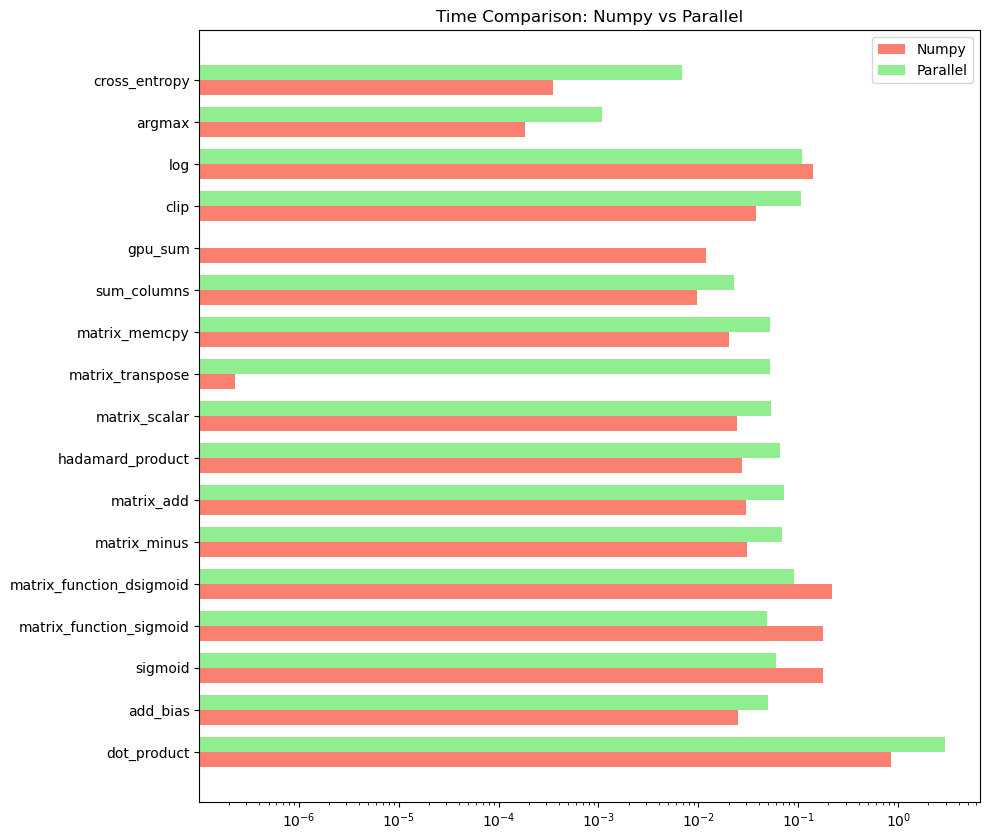

In [ ]:
def plot_results_timeit(results, title):
    bases = {}
    for key, res in results.items():
        if key.endswith("_numpy"):
            base = key[:-6]
            bases.setdefault(base, {})["numpy"] = res.best
        elif key.endswith("_parallel"):
            base = key[:-9]
            bases.setdefault(base, {})["parallel"] = res.best
    labels = list(bases.keys())
    numpy_vals = [bases[l].get("numpy", np.nan) for l in labels]
    parallel_vals = [bases[l].get("parallel", np.nan) for l in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, len(labels)*0.5))
    ax.barh(x - width/2, numpy_vals, width, color='salmon', label='Numpy')
    ax.barh(x + width/2, parallel_vals, width, color='lightgreen', label='Parallel')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_xscale('log')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_results_timeit(results_time, "Time Comparison: Numpy vs Parallel")

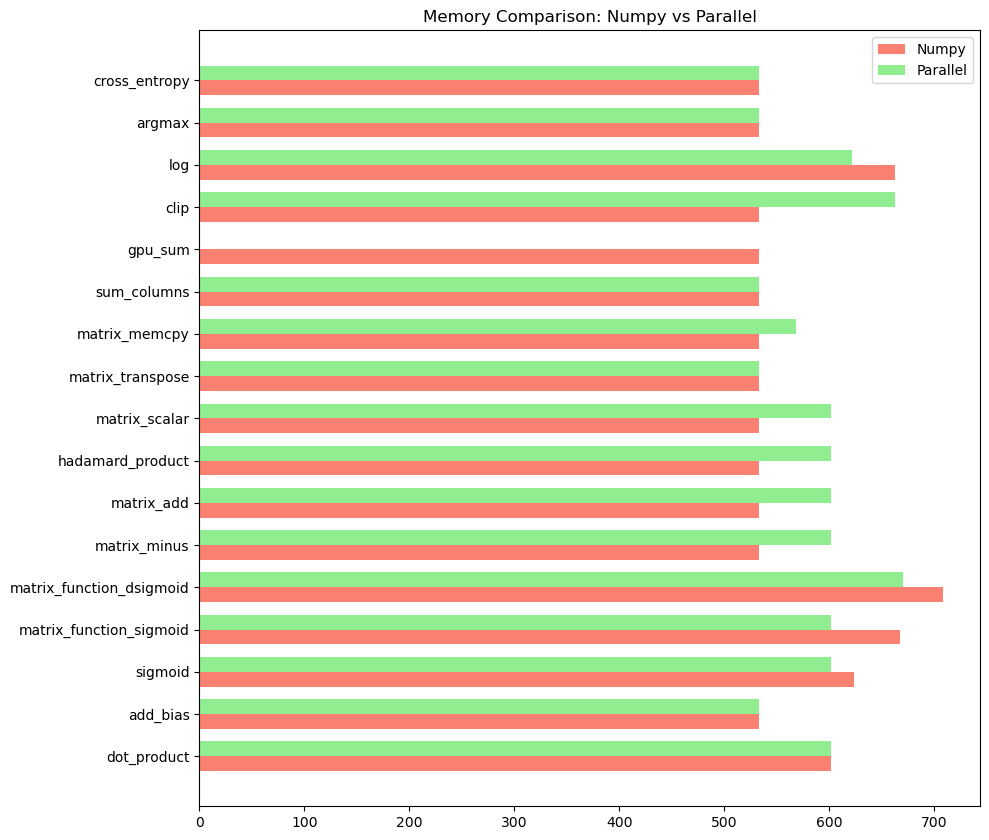

In [ ]:
def plot_results_memit(results, title):
    bases = {}
    for key, res in results.items():
        if key.endswith("_numpy"):
            base = key[:-6]
            bases.setdefault(base, {})["numpy"] = res.mem_usage[0]
        elif key.endswith("_parallel"):
            base = key[:-9]
            bases.setdefault(base, {})["parallel"] = res.mem_usage[0]
    labels = list(bases.keys())
    numpy_vals = [bases[l].get("numpy", np.nan) for l in labels]
    parallel_vals = [bases[l].get("parallel", np.nan) for l in labels]
    
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, len(labels)*0.5))
    ax.barh(x - width/2, numpy_vals, width, color='salmon', label='Numpy')
    ax.barh(x + width/2, parallel_vals, width, color='lightgreen', label='Parallel')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_results_memit(results_memory, "Memory Comparison: Numpy vs Parallel")

 ### Neural Network



 We use the same variable names and computation flow as the older version.

 The forward pass now uses GPU–parallel functions. The backward pass remains on CPU.

In [8]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))
def dsigmoid(x):
    s = sigmoid(x)
    return s*(1-s)

class Layer:
    def __init__(self, layer_number, number_of_neurons, nneurons_previous_layer, minibatch_size):
        self.number_of_neurons = number_of_neurons
        self.minibatch_size = minibatch_size
        self.activations = np.zeros((number_of_neurons, minibatch_size), dtype=np.float64)
        self.z = np.zeros((number_of_neurons, minibatch_size), dtype=np.float64)
        self.delta = np.zeros((number_of_neurons, minibatch_size), dtype=np.float64)
        self.weights = np.zeros((number_of_neurons, nneurons_previous_layer), dtype=np.float64)
        self.biases = np.zeros((number_of_neurons, 1), dtype=np.float64)
        if layer_number > 0:
            self.init_weight(nneurons_previous_layer)
    def init_weight(self, nneurons_prev):
        sigma = 1.0 / np.sqrt(nneurons_prev)
        r, c = self.weights.shape
        self.weights = np.random.normal(0.0, sigma, size=(r, c))

class ANN:
    def __init__(self, alpha, minibatch_size, number_of_layers, nneurons_per_layer):
        self.alpha = alpha
        self.minibatch_size = minibatch_size
        self.number_of_layers = number_of_layers
        self.layers = []
        for i in range(number_of_layers):
            if i == 0:
                self.layers.append(Layer(i, nneurons_per_layer[i], nneurons_per_layer[i], minibatch_size))
            else:
                self.layers.append(Layer(i, nneurons_per_layer[i], nneurons_per_layer[i-1], minibatch_size))

def set_input(nn, input_matrix):
    matrix_memcpy_gpu(nn.layers[0].activations, input_matrix)

def forward(nn, activation_identifier):
    for l in range(1, nn.number_of_layers):
        layer_l = nn.layers[l]
        layer_prev = nn.layers[l-1]
        z1 = dot_product_gpu(layer_l.weights, layer_prev.activations)
        ones = np.ones((1, nn.minibatch_size), dtype=np.float64)
        z2 = dot_product_gpu(layer_l.biases, ones)
        layer_l.z = matrix_add_gpu(z1, z2)
        layer_l.activations = matrix_function_gpu(layer_l.z, activation_identifier)
    return nn.layers[-1].activations

def backward(nn, y, derivative_identifier):
    L = nn.number_of_layers - 1
    layer_L = nn.layers[L]
    tmp = matrix_minus_gpu(layer_L.activations, y)
    dfzL = matrix_function_gpu(layer_L.z, derivative_identifier)
    layer_L.delta = hadamard_product_gpu(tmp, dfzL)
    for l in range(L, 1, -1):
        layer_l = nn.layers[l]
        layer_lm1 = nn.layers[l-1]
        w_l_transp = matrix_transpose_gpu(layer_l.weights)
        delta_tmp = dot_product_gpu(w_l_transp, layer_l.delta)
        dfz = matrix_function_gpu(layer_lm1.z, derivative_identifier)
        layer_lm1.delta = hadamard_product_gpu(delta_tmp, dfz)
    for l in range(1, nn.number_of_layers):
        layer_l = nn.layers[l]
        layer_lm1 = nn.layers[l-1]
        a_lm1_transp = matrix_transpose_gpu(layer_lm1.activations)
        w1 = dot_product_gpu(layer_l.delta, a_lm1_transp)
        w1 = matrix_scalar_gpu(w1, nn.alpha / nn.minibatch_size)
        layer_l.weights = matrix_minus_gpu(layer_l.weights, w1)
        ones = np.ones((nn.minibatch_size, 1), dtype=np.float64)
        b1 = dot_product_gpu(layer_l.delta, ones)
        b1 = matrix_scalar_gpu(b1, nn.alpha / nn.minibatch_size)
        layer_l.biases = matrix_minus_gpu(layer_l.biases, b1)

def evaluate(nn, X, y):
    test_size = X.shape[1]
    nbatches = (test_size // nn.minibatch_size) * nn.minibatch_size
    correct = 0
    for i in range(0, nbatches, nn.minibatch_size):
        batch = X[:, i:i+nn.minibatch_size]
        set_input(nn, batch)
        forward(nn, "sigmoid")
        preds = argmax_gpu(nn.layers[-1].activations)
        correct += np.sum(preds == y[i:i+nn.minibatch_size])
    return correct

 ### Main Execution



 We load MNIST, prepare mini‑batches (transposing the input to shape (784, batch_size)) and train for 5 epochs.

In [9]:
DATA_PATH = "DATA"
train_img = read_images(os.path.join(DATA_PATH, "train-images.idx3-ubyte"))
train_label = read_labels(os.path.join(DATA_PATH, "train-labels.idx1-ubyte"))
test_img = read_images(os.path.join(DATA_PATH, "t10k-images.idx3-ubyte"))
test_label = read_labels(os.path.join(DATA_PATH, "t10k-labels.idx1-ubyte"))

alpha = 0.05
minibatch = 16
sizes = [784, 30, 10]
net = ANN(alpha, minibatch, 3, sizes)
NEPOCHS = 5

def one_hot(indices, n_classes):
    m = np.zeros((n_classes, len(indices)), dtype=np.float64)
    m[indices, np.arange(len(indices))] = 1.0
    return m

In [10]:
N_train = train_img.shape[0]
print(f"Initial accuracy: {evaluate(net, (test_img[:1000].T.astype(np.float64))/255.0, test_label[:1000])}")
for epoch in range(NEPOCHS):
    indices = np.arange(N_train)
    np.random.shuffle(indices)
    ce_total = 0.0
    n_batches = 0
    for i in tqdm(range(0, N_train - minibatch + 1, minibatch)):
        batch_idx = indices[i:i+minibatch]
        x = (train_img[batch_idx].T.astype(np.float64)) / 255.0
        y = one_hot(train_label[batch_idx], 10)
        output = forward(net, "sigmoid")
        eps = 1e-12
        output_clip = clip_gpu(output, eps, 1-eps)
        log_vals = log_gpu(output_clip)
        ce = -gpu_sum(hadamard_product_gpu(y, log_vals)) / minibatch
        ce_total += ce
        backward(net, y, "dsigmoid")
        n_batches += 1
    acc = evaluate(net, (test_img[:1000].T.astype(np.float64))/255.0, test_label[:1000])
    print(f"Epoch {epoch} - Acc: {100.0*acc/1000:.2f}%, CE: {ce_total/n_batches:.4f}")

c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: Numb

Initial accuracy: 110


  0%|          | 0/3750 [00:00<?, ?it/s]c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\sacha\miniconda3\envs\ECN_GPU\Lib\site-pack

KeyboardInterrupt: 

In [11]:
acc = evaluate(net, (test_img[:1000].T.astype(np.float64))/255.0, test_label[:1000])
print(f"Final Test Accuracy: {100.0*acc/1000:.2f}%")

Final Test Accuracy: 7.50%


In [17]:
import time

# 1) Monkey-patch cuda.to_device and copy_to_host to measure transfer time
old_to_device = cuda.to_device
old_copy_to_host = cuda.devicearray.DeviceNDArray.copy_to_host

# We'll store time spent in CPU↔GPU memory copies in this global variable
mem_transfer_time = 0.0

def timed_to_device(arr):
    global mem_transfer_time
    start = time.time()
    result = old_to_device(arr)
    mem_transfer_time += (time.time() - start)
    return result

def timed_copy_to_host(self, ary=None):
    global mem_transfer_time
    start = time.time()
    result = old_copy_to_host(self, ary)
    mem_transfer_time += (time.time() - start)
    return result

# Override the original functions
cuda.to_device = timed_to_device
cuda.devicearray.DeviceNDArray.copy_to_host = timed_copy_to_host

# 2) Now run a single epoch of training and measure total time vs. memory copy time
start_time = time.time()

# -- Create a new net or reuse your existing net if you like --
alpha = 0.05
minibatch = 16
sizes = [784, 30, 10]
net_single_epoch = ANN(alpha, minibatch, 3, sizes)

# Only 1 epoch to highlight the overhead from CPU↔GPU
N_train = train_img.shape[0]
indices = np.arange(N_train)
np.random.shuffle(indices)

ce_total = 0.0
n_batches = 0

for i in tqdm(range(0, N_train - minibatch + 1, minibatch)):
    batch_idx = indices[i : i + minibatch]
    x = (train_img[batch_idx].T.astype(np.float64)) / 255.0
    y = one_hot(train_label[batch_idx], 10)
    output = forward(net_single_epoch, "sigmoid")
    # Cross‑entropy
    eps = 1e-12
    output_clip = clip_gpu(output, eps, 1 - eps)
    log_vals = log_gpu(output_clip)
    ce = -gpu_sum(hadamard_product_gpu(y, log_vals)) / minibatch
    ce_total += ce
    backward(net_single_epoch, y, "dsigmoid")
    n_batches += 1

end_time = time.time()

# 3) Print out the numbers
total_training_time = end_time - start_time



  0%|          | 0/3750 [00:00<?, ?it/s]

KeyboardInterrupt



In [14]:
print(f"Total time for 1 epoch :   {total_training_time:.4f} seconds")
print(f"Memory-transfer time :     {mem_transfer_time:.4f} seconds")
print(f"Share of time in memcopy : {(mem_transfer_time / total_training_time) * 100:.2f}%")

Total time for 1 epoch :   150.4367 seconds
Memory-transfer time :     127.3007 seconds
Share of time in memcopy : 84.62%


In [16]:
print(train_img.shape)

(60000, 784)


In [18]:
N_train / minibatch

3750.0